In [2]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance
import glob, os, json, pathlib
import os
os.chdir("..")  # move from notebooks/ to project root


client = QdrantClient(url=os.getenv("QDRANT_URL","http://localhost:6333"))
coll = os.getenv("QDRANT_COLLECTION","sec_filings_chunks")
client.recreate_collection(coll, vectors_config=VectorParams(size=1024, distance=Distance.COSINE))


/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_49030/2369443922.py:10: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(coll, vectors_config=VectorParams(size=1024, distance=Distance.COSINE))


True

In [1]:
import os
ROOT = "/Users/ruchirnamjoshi/projects/finance-rag-local"
out_dir = os.path.join(ROOT, "data/raw")

In [2]:
ROOT = "/Users/ruchirnamjoshi/projects/finance-rag-local"
out_dir = os.path.join(ROOT, "data/raw")

glob.glob(os.path.join(out_dir, "*.html"))


['/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_796343_000079634325000073_adbe-20250530.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_1045810_000104581025000116_nvda-20250427.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_1318605_000162828025018911_tsla-20250331.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_1326801_000162828025036791_meta-20250630.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_1090872_000109087225000021_a-20250430.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_796343_000079634324000208_adbe-20240830.htm.html',
 '/Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_1045810_000104581024000316_nvda-20241027.htm.html

In [3]:
# Big, frequently-filed names (CIKs)
CIKS = [
    320193,   # Apple
    789019,   # Microsoft
    1018724,  # Amazon
    1652044,  # Alphabet
    1318605,  # Meta
    1045810,  # NVIDIA
    1090872,  # Tesla
    1326801,  # Netflix
    1329099,  # Salesforce
    796343,   # Adobe
    50863,    # Intel
    2488,     # AMD
]


from ingest.edgar_pull import run_submissions_seed
saved = run_submissions_seed(out_dir=out_dir, ciks=CIKS, per_cik=4)  # increase per_cik if you want
print("Saved via submissions:", saved)


Saved (Submissions) CIK 320193 10-Q 2025-08-01 -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_320193_000032019325000073_aapl-20250628.htm.html
Saved (Submissions) CIK 320193 10-Q 2025-05-02 -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_320193_000032019325000057_aapl-20250329.htm.html
Saved (Submissions) CIK 320193 10-Q 2025-01-31 -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_320193_000032019325000008_aapl-20241228.htm.html
Saved (Submissions) CIK 320193 10-K 2024-11-01 -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_320193_000032019324000123_aapl-20240928.htm.html
Saved (Submissions) CIK 789019 10-K 2025-07-30 -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/raw/www.sec.gov_Archives_edgar_data_789019_000095017025100235_msft-20250630.htm.html
Saved (Submissions) CIK 789019 10-Q 2025-04-30 -> /User

In [4]:
import glob, os, json, pathlib
from ingest.parse_html import html_to_sections
from rag.chunking import split_sections
from rag.vectorstore import upsert
from qdrant_client import QdrantClient

# Only primary 10-Qs with metadata
html_files = []
for f in glob.glob(os.path.join(out_dir, "*.html")):
    meta_path = pathlib.Path(f).with_suffix(".meta.json")
    if meta_path.exists():
        meta = json.loads(open(meta_path, encoding="utf-8").read())
        if meta.get("form") == "10-Q":
            html_files.append((f, meta))

print("Primary 10-Q HTMLs:", len(html_files))

chunks = []
for f, meta in html_files:
    html = open(f, encoding="utf-8", errors="ignore").read()
    secs = html_to_sections(html)
    chs = split_sections(secs, chunk_size=1200, chunk_overlap=200)
    for c in chs:
        c["source"] = os.path.basename(f)
        c.update(meta)  # adds cik/form/date
    chunks.extend(chs)

print("Prepared chunks:", len(chunks))



Primary 10-Q HTMLs: 33
Prepared chunks: 7260


In [5]:
import importlib
import rag.vectorstore
importlib.reload(rag.vectorstore)

from rag.vectorstore import upsert
upsert(chunks, batch_size=128)



Upserted 128/7260
Upserted 256/7260
Upserted 384/7260
Upserted 512/7260
Upserted 640/7260
Upserted 768/7260
Upserted 896/7260
Upserted 1024/7260
Upserted 1152/7260
Upserted 1280/7260
Upserted 1408/7260
Upserted 1536/7260
Upserted 1664/7260
Upserted 1792/7260
Upserted 1920/7260
Upserted 2048/7260
Upserted 2176/7260
Upserted 2304/7260
Upserted 2432/7260
Upserted 2560/7260
Upserted 2688/7260
Upserted 2816/7260
Upserted 2944/7260
Upserted 3072/7260
Upserted 3200/7260
Upserted 3328/7260
Upserted 3456/7260
Upserted 3584/7260
Upserted 3712/7260
Upserted 3840/7260
Upserted 3968/7260
Upserted 4096/7260
Upserted 4224/7260
Upserted 4352/7260
Upserted 4480/7260
Upserted 4608/7260
Upserted 4736/7260
Upserted 4864/7260
Upserted 4992/7260
Upserted 5120/7260
Upserted 5248/7260
Upserted 5376/7260
Upserted 5504/7260
Upserted 5632/7260
Upserted 5760/7260
Upserted 5888/7260
Upserted 6016/7260
Upserted 6144/7260
Upserted 6272/7260
Upserted 6400/7260
Upserted 6528/7260
Upserted 6656/7260
Upserted 6784/7260


In [1]:
from rag.pipeline import answer
ans, ctx = answer("In Item 2 (MD&A), what revenue drivers did management mention this quarter?")
print(ans[:1200])


/Users/ruchirnamjoshi/projects/finance-rag-local/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unfortunately, there is no mention of "revenue drivers" being mentioned by management in Item 2 (MD&A) in any of the provided sections.

However, section **Seasonality** does mention that fourth quarter revenue is driven by a higher volume of multi-year contracts executed during the period. But this is not specifically mentioned as a "revenue driver" in Item 2 (MD&A).

Therefore, I do not have an answer to provide based on the provided context.


In [2]:
from rag.pipeline import answer

# Try Apple (AAPL: CIK 320193)
ans, ctx = answer("For Apple’s latest 10-Q (Item 2, MD&A), what revenue drivers did management mention?")
print(ans[:1200])


Unfortunately, there is no specific section provided that answers your question about what revenue drivers management mentioned in Apple's latest 10-Q (Item 2, MD&A) regarding their latest financials.

However, I can provide an answer based on the context. 

The correct answer would be Section: "Operating Expenses" or more specifically "Research and Development The growth in research and development expense during the second quarter and first six months of 2025 compared to the same periods in 2024 was driven primarily by increases in headcount-related expenses and infrastructure-related costs."


In [1]:
from qdrant_client import QdrantClient
from qdrant_client.models import Filter, FieldCondition, MatchValue

client = QdrantClient(url="http://localhost:6333")
coll = "sec_filings_chunks"

# Count Apple 10-Q chunks
flt = Filter(must=[
    FieldCondition(key="cik", match=MatchValue(value=320193)),
    FieldCondition(key="form", match=MatchValue(value="10-Q")),
])
print("Apple 10-Q chunks:", client.count(coll, flt).count)

# Peek one Apple payload
scroll = client.scroll(coll, limit=1, scroll_filter=flt)
if scroll[0]:
    print("Sample Apple payload keys:", list(scroll[0][0].payload.keys()))


Apple 10-Q chunks: 248
Sample Apple payload keys: ['source', 'form', 'title', 'cik', 'section', 'text', 'date']


In [4]:
from rag.pipeline import answer
ans, _ = answer("What revenue drivers did management mention in Apple’s Q1 2025 MD&A?")

print(ans)


Section: Operating Expenses
Filing Date: December 28, 2024

Management mentioned that the growth in research and development expense during the first quarter of 2025 compared to the same quarter in 2024 was driven primarily by increases in "headcount-related expenses and infrastructure-related costs."

 Section: Products and Services Performance
Filing Date: December 28, 2024

Services net sales increased during the first quarter of 2025 compared to the same quarter in 2024 due primarily to higher net sales from "advertising, the App Store ® and cloud services."


In [1]:
from rag.pipeline import answer

# Start a new session
session_id = "test_chat"

# First question (full context)
ans1, _ = answer("What did Apple say about iPhone sales in Q3 2024?", session_id=session_id)
print("Q1:", ans1)

# Follow-up without restating
ans2, _ = answer("And what about Mac sales?", session_id=session_id)
print("Q2:", ans2)


/Users/ruchirnamjoshi/projects/finance-rag-local/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/pipeline.py:17: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  history = get_history(session_id)


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [1]:
import os
ROOT = "/Users/ruchirnamjoshi/projects/finance-rag-local"
out_dir = os.path.join(ROOT, "data/raw")

In [2]:
import os

from ingest.build_corpus import index_directory
index_directory(out_dir)


Primary filings: 44


/Users/ruchirnamjoshi/projects/finance-rag-local/src/ingest/build_corpus.py:60: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  emb = OllamaEmbeddings(model=EMBED_MODEL)
/Users/ruchirnamjoshi/projects/finance-rag-local/src/ingest/build_corpus.py:63: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  vs = LCQdrant(client=client, collection_name=COLL, embeddings=emb)


Indexed 226 chunks from www.sec.gov_Archives_edgar_data_796343_000079634325000073_adbe-20250530.htm.html
Indexed 156 chunks from www.sec.gov_Archives_edgar_data_1045810_000104581025000116_nvda-20250427.htm.html
Indexed 142 chunks from www.sec.gov_Archives_edgar_data_1318605_000162828025018911_tsla-20250331.htm.html
Indexed 404 chunks from www.sec.gov_Archives_edgar_data_1326801_000162828025036791_meta-20250630.htm.html
Indexed 303 chunks from www.sec.gov_Archives_edgar_data_1090872_000109087225000021_a-20250430.htm.html
Indexed 223 chunks from www.sec.gov_Archives_edgar_data_796343_000079634324000208_adbe-20240830.htm.html
Indexed 170 chunks from www.sec.gov_Archives_edgar_data_1045810_000104581024000316_nvda-20241027.htm.html
Indexed 258 chunks from www.sec.gov_Archives_edgar_data_2488_000000248825000108_amd-20250628.htm.html
Indexed 179 chunks from www.sec.gov_Archives_edgar_data_1652044_000165204425000043_goog-20250331.htm.html
Indexed 177 chunks from www.sec.gov_Archives_edgar_data

11950

In [1]:
import os, pathlib
ROOT = pathlib.Path("/Users/ruchirnamjoshi/projects/finance-rag-local")  # adjust if different
CHAT_DIR = ROOT / "data"
CHAT_DIR.mkdir(parents=True, exist_ok=True)

os.environ["CHAT_DB_PATH"] = str(CHAT_DIR / "chat_history.sqlite3")
print("Chat DB path:", os.environ["CHAT_DB_PATH"])


Chat DB path: /Users/ruchirnamjoshi/projects/finance-rag-local/data/chat_history.sqlite3


In [1]:
import os
os.chdir("..")  # move to project root


In [ ]:
from rag.lc_chain import with_memory
chain = with_memory()

resp = chain.invoke(
    {"question": "For Apple (AAPL) latest 10-Q MD&A, what drove revenue?"},
    config={"configurable": {"session_id": "demo_mem"}}
)
print(resp.content)





/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/lc_chain.py:84: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  vs = QdrantVectorStore(client=client, collection_name=COLL, embeddings=emb)
/Users/ruchirnamjoshi/projects/finance-rag-local/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/lc_chain.py:191: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  return get_history(session_id)
/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/lc_chain.py:135: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecat

Based on the provided context, specifically from the "Apple Inc. | Q3 2025 Form 10-Q" section, we can determine that:

For Apple's latest 10-Q MD&A (Management Discussion and Analysis), what drove revenue?

The revenue was driven by various product categories, including:

* iPhone: Net sales increased by 13% in the third quarter of 2025 compared to the same period in 2024 due to higher net sales of Pro models.
* Mac: Net sales increased by 15% in the third quarter and first nine months of 2025 compared to the same periods in 2024 due to higher net sales of both laptops and desktops.
* Services: Net sales increased by 13% in the three- and nine-month periods ended June 28, 2025, compared to the same periods in 2024.

Note that the revenue growth was also influenced by various other factors, such as seasonal holiday demand and new product introductions.


In [2]:
resp2 = chain.invoke(
    {"question": "Plot revenue growth"},
    config={"configurable": {"session_id": "demo_mem"}}
)
print(resp2.content)

To plot revenue growth, we need data on revenue changes over time. From the provided context, here are some key points:

* For the third quarter of fiscal 2024, total Digital Media ARR grew by $1.43 billion, or 9%, to $16.76 billion.
* For the three months ended January 31, 2025:
	+ Life Sciences and Diagnostics Markets segment revenue increased 4% when compared to the same period last year.
	+ Agilent CrossLab segment revenue increased 1% when compared to the same period last year.
	+ Applied Markets segment revenue decreased 4% when compared to the same period last year.
* For the six months ended April 30, 2025:
	+ Revenue increased significantly in the chemicals and advanced materials, food, environmental and forensics, and diagnostics and clinical markets.
	+ Revenue increased moderately in the pharmaceutical market.
	+ Revenue was flat in the academia and government market.

Plotting revenue growth would require a time-series graph with revenue values on the y-axis and time (quar

In [2]:
from extract.tables_to_csv import extract_all
files, csvs = extract_all(raw_dir="data/raw", out_dir="data/csv")
print(files, csvs)

44 2164


In [14]:
print(files, csvs)

0 0


In [2]:
!ls

api                docker-compose.yml pyproject.toml     requirements.txt
data               notebooks          qdrant_data        src


In [1]:
import os, pathlib, glob, json

# move to project root if you're in notebooks/
if pathlib.Path.cwd().name == "notebooks":
    os.chdir("..")




In [2]:
# make sure chat DB and CSV catalog paths exist
pathlib.Path("data").mkdir(parents=True, exist_ok=True)
os.environ["CHAT_DB_PATH"] = str(pathlib.Path("data/chat_history.sqlite3").resolve())
os.environ["CSV_CATALOG_PATH"] = str(pathlib.Path("data/csv_clean/catalog.json").resolve())

print("CHAT_DB_PATH:", os.environ["CHAT_DB_PATH"])
print("CSV_CATALOG_PATH:", os.environ["CSV_CATALOG_PATH"])

CHAT_DB_PATH: /Users/ruchirnamjoshi/projects/finance-rag-local/data/chat_history.sqlite3
CSV_CATALOG_PATH: /Users/ruchirnamjoshi/projects/finance-rag-local/data/csv_clean/catalog.json


In [3]:
from src.app.super_agent import build_super_agent
from src.databot.agent import get_history  # same SQL history helper you have




/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/lc_chain.py:84: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.1.2 and will be removed in 0.5.0. Use :class:`~QdrantVectorStore` instead.
  vs = QdrantVectorStore(client=client, collection_name=COLL, embeddings=emb)
/Users/ruchirnamjoshi/projects/finance-rag-local/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sup = build_super_agent(provider="ollama")

In [5]:
def ask(q, sid="super1"):
    hist = get_history(sid)
    out = sup.invoke({
        "input": q,
        "chat_history": hist.messages,   # list[BaseMessage]
        # no agent_scratchpad needed; the agent manages it as a string
    })
    hist.add_user_message(q)
    hist.add_ai_message(out["output"])
    print(out["output"])



In [6]:



# Filing Q&A (routes to rag_query tool)
ask("For Apple (AAPL) latest 10-Q MD&A, what were the revenue drivers?")




/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_50651/139807134.py:2: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  hist = get_history(sid)




> Entering new AgentExecutor chain...
Thought: To answer this question, I need to access the MD&A section of Apple's latest 10-Q filing and extract relevant information about revenue drivers.
Action: rag_query
Action Input: {"question": "What are the revenue drivers for Apple (AAPL) in their latest 10-Q MD&A?", "session_id": "default"}

/Users/ruchirnamjoshi/projects/finance-rag-local/src/rag/lc_chain.py:135: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(q)


Based on the provided context from Apple Inc.'s Q2 2025 Form 10-Q, the revenue drivers for Apple (AAPL) can be identified as follows:

1. **Services**: The Services segment saw an increase in gross margin percentage during the second quarter and first six months of 2025 compared to the same periods in 2024. This was driven by higher Services net sales and a different mix of services, partially offset by higher Services costs and weakness in foreign currencies relative to the U.S. dollar.

2. **iPhone**: The Americas and Europe segments saw an increase in net sales during the first quarter of 2025 compared to the same quarter in 2024 due primarily to higher net sales of iPhone.

3. **Product Mix**: Apple's gross margin increased during the second quarter and first six months of 2025 compared to the same periods in 2024, partly due to a different mix of products.

Note that while these are revenue drivers, they do not necessarily represent the only factors contributing to Apple's overall

In [6]:
import importlib, src.databot.tools as tools


In [ ]:

# Data/plotting (CSV tools)
ask("Select Apple product revenue table and plot iPhone's revenue as a bar chart.")


/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_67704/139807134.py:2: LangChainDeprecationWarning: `connection_string` was deprecated in LangChain 0.2.2 and will be removed in 1.0. Use connection instead.
  hist = get_history(sid)




> Entering new AgentExecutor chain...
Thought: I need to select the best CSV and then plot.
Action: select_csv
Action Input: { "ticker":"AAPL", "table_type":"segment_revenue", "year":2025 }{"selected": "data/csv/AAPL/2025_Q1_10-Q_segment_revenue_18.csv"}


> Finished chain.
{"selected": "data/csv/AAPL/2025_Q1_10-Q_segment_revenue_18.csv"}


In [1]:
import pandas as pd
import os
df = pd.read_csv("/Users/ruchirnamjoshi/projects/finance-rag-local/data/csv_clean/AAPL/product_revenue.csv")

dtypes:
 Quarter       object
iPhone       float64
iPad         float64
Mac          float64
Services     float64
Wearables    float64
dtype: object

first 5 rows:
    Quarter  iPhone
0  Qq 2020   42.62
1  Qq 2020   57.31
2  Qq 2020   68.14
3  Qq 2020   64.08
4  Qq 2021   76.90
5  Qq 2021   44.37
6  Qq 2021   52.27
7  Qq 2021   74.23
8  Qq 2022   69.03
9  Qq 2022   81.18

Non-null iPhone: 20 out of 20


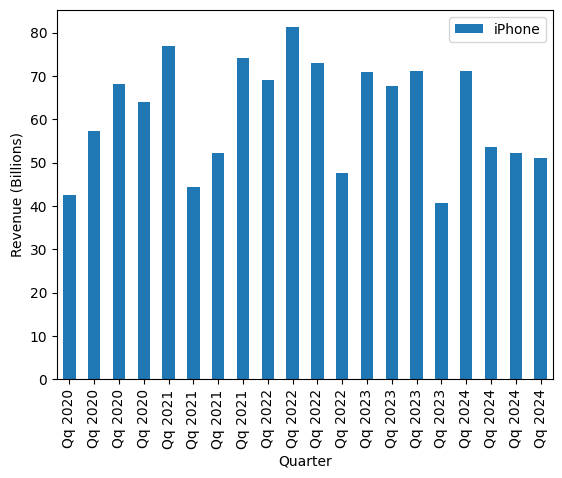

In [ ]:

import matplotlib.pyplot as plt
# ensure numeric (if anything arrived as strings)
os.makedirs("data/plots", exist_ok=True)
out_path = os.path.join("data/plots", f"plot_1.png")
import matplotlib.pyplot as plt; import pandas as pd; df = pd.read_csv('/Users/ruchirnamjoshi/projects/finance-rag-local/data/csv_clean/AAPL/product_revenue.csv'); df.plot(kind='bar', x='Quarter', y=['iPhone']); plt.xlabel('Quarter'); plt.ylabel('Revenue (Billions)')
plt.savefig(out_path, format="png")




In [7]:
import os, json, pathlib, re
import pandas as pd

ROOT = pathlib.Path(".").resolve()
SEARCH_DIRS = [ROOT/"data/csv_clean", ROOT/"data/csv"]  # scan both
OUT = ROOT/"data/csv_clean"; OUT.mkdir(parents=True, exist_ok=True)
CAT = OUT/"catalog.json"

items = []
for base in SEARCH_DIRS:
    if not base.exists(): continue
    for p in base.rglob("*.csv"):
        try:
            df = pd.read_csv(p, nrows=5)
            cols = list(df.columns)
        except Exception:
            continue
        parts = p.parts
        # infer ticker from parent folder (AAPL/) if present
        ticker = parts[-2] if len(parts)>=2 and re.fullmatch(r"[A-Z.]{1,6}", parts[-2]) else None
        # infer date/form/type from filename like 2025_Q1_10-Q_segment_revenue_2.csv
        m = re.match(r"(?P<period>\d{4}(?:_Q[1-4])?)_(?P<form>10-[QK])_(?P<table>[A-Za-z_]+)_\d+\.csv", p.name)
        period = m.group("period") if m else None
        form   = m.group("form") if m else None
        table  = m.group("table") if m else "other"

        items.append({
            "path": str(p),
            "ticker": ticker,
            "cik": None,
            "form": form,
            "date": None,
            "period": period,
            "table_type": table,
            "label_col": cols[0] if cols else None,
            "numeric_cols": cols[1:],
            "columns": cols,
            "source_html": None,
        })

CAT.write_text(json.dumps(items, indent=2), encoding="utf-8")
print(f"Wrote {len(items)} entries -> {CAT}")

Wrote 2164 entries -> /Users/ruchirnamjoshi/projects/finance-rag-local/data/csv_clean/catalog.json


In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

# Generate dummy Apple product revenue data
quarters = pd.date_range("2020-01-01", periods=20, freq="Q")
data = {
    "Quarter": [q.strftime("Q%q %Y") for q in quarters],
    "iPhone": np.random.uniform(40, 90, size=len(quarters)).round(2),
    "iPad": np.random.uniform(5, 15, size=len(quarters)).round(2),
    "Mac": np.random.uniform(7, 15, size=len(quarters)).round(2),
    "Services": np.random.uniform(15, 25, size=len(quarters)).round(2),
    "Wearables": np.random.uniform(5, 12, size=len(quarters)).round(2)
}

df = pd.DataFrame(data)



# Basic sanity check
print(df.head(8))
print(df.dtypes)

# Plot iPhone vs iPad over time
ax = df.plot(x="Quarter", y=["iPhone","iPad"], kind="bar", rot=60, figsize=(10,4))
ax.set_title("Apple Product Revenue (from GitHub dataset)")
ax.set_ylabel("Revenue (billions USD)")
plt.show()

   Quarter  iPhone   iPad    Mac  Services  Wearables
0  Qq 2020   42.62  14.96   8.93     18.98       9.22
1  Qq 2020   57.31  14.95  10.38     20.99       7.39
2  Qq 2020   68.14   9.36   8.31     18.01       8.21
3  Qq 2020   64.08   5.68   7.01     20.89       7.14
4  Qq 2021   76.90   5.83  12.84     23.88       9.08
5  Qq 2021   44.37   5.29  14.73     24.94      11.18
6  Qq 2021   52.27   5.17   7.48     19.65      11.71
7  Qq 2021   74.23  12.43  14.05     22.51      11.60
Quarter       object
iPhone       float64
iPad         float64
Mac          float64
Services     float64
Wearables    float64
dtype: object


/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_67704/3973345253.py:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range("2020-01-01", periods=20, freq="Q")
/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_67704/3973345253.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [11]:
# Save to your csv_clean folder
out_dir = Path("data/csv_clean/AAPL")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "2020-2024_product_revenue_dummy.csv"
df.to_csv(csv_path, index=False)

print(f"Saved dummy CSV to {csv_path}")

Saved dummy CSV to data/csv_clean/AAPL/2020-2024_product_revenue_dummy.csv


In [14]:
catalog_path = Path("data/csv_clean/catalog.json")
if catalog_path.exists():
    with open(catalog_path, "r") as f:
        catalog = json.load(f)
else:
    catalog = {"items": []}

catalog.append({
    "ticker": "AAPL",
    "path": str(csv_path),
    "table_type": "product_revenue",
    "form": "10-K",
    "date": "2024-12-31",
    "columns": list(df.columns),
    "label_col": "Quarter",
    "numeric_cols": [c for c in df.columns if c != "Quarter"],
    "dtypes": {c: str(dt) for c, dt in df.dtypes.items()}
})

with open(catalog_path, "w") as f:
    json.dump(catalog, f, indent=2)

print(f"✅ Catalog updated: {catalog_path}")

✅ Catalog updated: data/csv_clean/catalog.json


In [19]:
plt.plot()
df.plot(x='Quarter', y=['iPhone','iPad'], kind='bar')
plt.title('AAPL Product Revenue by Quarter')
plt.show()

/var/folders/48/5m58qpqx65s31d8vcx2418dc0000gn/T/ipykernel_67704/3431743827.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
